# Individual Category Time Series Modelling
Use the most up-to-date CPI data from the Stats SA website. Investigate each category individualy and compare the forcasts from the Holt-Winters with an ARIMA model.

Determine which additional data can be used to improve the forecasting for each category and where necessary fit a VAR or VARMA model after making the time series stationary.

## Import Libraries

In [360]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import pathlib


# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.arima.utils import nsdiffs

from sklearn.metrics import mean_squared_error
from math import sqrt

# Import packages
import plotly.graph_objects as go

# import nbformat
import plotly.io as pio
pio.renderers.default='notebook_connected'


In [361]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Define Date for Prediction
This will be updated every month to include the new date

In [362]:
forecast_start_date = '2023-08-01'
month = 'Aug'

## Import the Different Data Sets
Import the following data sets:

- `EXCEL - CPI(5 and 8 digit) from Jan 2017 (202306).xlsx`: this will be used to do the EDA and predictions of the CPI values.

In [363]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [364]:
raw_df = pd.read_excel(path + "/data/EXCEL - CPI(5 and 8 digit) from Jan 2017 (202307).xlsx", dtype="object")

## Review the Historical CPI data and Create a Summary DataFrame
There are 12 main categories that are used to calculate the Headline CPI. Each category has a number of sub categories. This data set contains the CPI on sub-category level.

Create a dataset where the CPI is calculated on the category level. These values will then be used in the models to predict the CPI for the different categories as well as the Headline CPI.

In terms of cleaning the data, I will do the following:
- Remove unnecessary columns.
- Change column headers to make them more explanatory.
- Replace all `..` entries with a `0`. 
- Combine the `Super maize` and `Special maize` categories into a single `Maize meal` category, to correspond with the current use of maize meal.
- Create a function to calculate the CPI values for each month using the weights provided in the file.


In [365]:
# Create a category dictionary with the category code and description
category_dict = {"01":"Food and non-alcoholic beverages",
                 "02":"Alcoholic beverages and tobacco",
                 "03":"Clothing and footwear",
                 "04":"Housing and utilities",
                 "05":"Household contents and services",
                 "06":"Health",
                 "07":"Transport",
                 "08":"Communication",
                 "09":"Recreation and culture",
                 "10":"Education",
                 "11":"Restaurants and hotels",
                 "12":"Miscellaneous goods and services",
                 "headline": "headline CPI"
}

In [366]:
def get_montly_cpi(raw_df):
    """Function that takes the raw cpi data for each product from statssa and calculates the cpi value per category
    
    Arguments:
    ----------
    raw_df: pandas dataframe
            dataframe containing raw data from statsa

    Return:
    -------
    df_cpi: pandas dataframe
            dataframe containing the monthly cpi per category
    """

    # 1. remove unecessary columns and rename
    list_cols_to_drop = ['H01','H02','H05','H06','H07']
    cat_cpi_df = raw_df.copy().drop(list_cols_to_drop, axis=1).copy()

    cat_cpi_df.rename(columns = {'H03':'category_codes', 'H04':'category_descr', 
                             'Weight (All urban)':'weights_urban'}, inplace = True)

    # 2. replace .. with zeros
    cat_cpi_df.replace("..", 0, inplace=True)

    # 3. combine maize meal categories
    cat_cpi_df.iloc[17:19] = cat_cpi_df.iloc[17:19].copy().apply(pd.to_numeric, errors='coerce')
    divided_row = (cat_cpi_df.iloc[17].copy()+cat_cpi_df.iloc[18].copy())/2
    cat_cpi_df.iloc[15] = [divided_row[i] if value == 0 else value for i, value in enumerate(cat_cpi_df.iloc[15].copy())]  
    cat_cpi_df.drop([cat_cpi_df.index[17], cat_cpi_df.index[18]], inplace=True)

    # Convert the 'weights_urban' column to float
    cat_cpi_df['weights_urban'] = cat_cpi_df['weights_urban'].astype('float')

    # 4. calculate cpi
    # Assign a main category code to each raw data row.
    main_category = []
    for index, row in cat_cpi_df.iterrows():
        if (len(row['category_codes']) == 8) & (row['category_codes'][:2] in ["01","02"]):
            main_category.append(row['category_codes'][:2])
        elif (len(row['category_codes']) == 5):  # & (row['category_codes'][:2] not in ["04","07"]):
            main_category.append(row['category_codes'][:2])
        else:
            main_category.append("no")
    
    cat_cpi_df['main_category_code'] = main_category
    
    # Drop the rows where the main_category_code is "no". That is to prevent double counting.
    # Some categories have a sub category included in the data.
    cat_cpi_df.drop(cat_cpi_df[cat_cpi_df['main_category_code'] == "no"].index, inplace = True)
    
    # Sum the weights for each category
    sum_weights = cat_cpi_df.groupby('main_category_code')['weights_urban'].sum()
    
    # create new cpi dataframe
    cpi_df = pd.DataFrame()
    
    # For each month create the headline CPI value and the CPI value per category. 
    for col in range(3, cat_cpi_df.shape[1]-1):
        cat_cpi_df = cat_cpi_df.copy()
        column_name = cat_cpi_df.columns[col]
        cat_cpi_df['weighted_index_' + column_name] = cat_cpi_df['weights_urban']*cat_cpi_df[column_name]
    
        sum_weighted_index = cat_cpi_df.groupby('main_category_code')['weighted_index_' + column_name].sum()
        
        # Concatenate the DataFrames horizontally
        concat_df = pd.concat([sum_weights, sum_weighted_index], axis=1)
        
        # Add a row that sums the values in the columns
        sums_df = pd.DataFrame(concat_df.sum().values.reshape(1, -1), columns=concat_df.columns)
        sums_df = sums_df.set_index(pd.Index(["headline"]))
        
        # Concatenate the headline dataframe to the categories
        month_cpi_df = pd.concat([concat_df, sums_df], axis=0) 
        
        # Calculate the CPI value
        month_cpi_df['cpi_' + column_name] = (month_cpi_df['weighted_index_' + column_name] / 
                                            month_cpi_df['weights_urban']).round(1)
        
        cpi_df = pd.concat([cpi_df, month_cpi_df[['weights_urban', 'cpi_'+column_name]]], axis=1)
    
    # Remove duplicate weights columns and reset the index
    cpi_df = cpi_df.loc[:, ~cpi_df.columns.duplicated()]
    cpi_df = cpi_df.reset_index().rename(columns={'index':'category'})
    
    # Dataframe with just the CPI values:
    cpi_df = cpi_df.drop('weights_urban', axis=1).copy()
    transposed_cpi_df = cpi_df.set_index('category').transpose().reset_index()
    transposed_cpi_df['date'] = transposed_cpi_df['index'].apply(lambda x: x.split('M')[-1])
    transposed_cpi_df['date'] = transposed_cpi_df['date'].apply(lambda x: x[:4] + '-' + x[-2:])
    # change month to datetime format
    transposed_cpi_df['date'] = pd.to_datetime(transposed_cpi_df['date']).dt.strftime('%Y-%m')
    transposed_cpi_df = transposed_cpi_df.set_index('date')
    transposed_cpi_df.index = pd.DatetimeIndex(transposed_cpi_df.index.values)
    
    return(transposed_cpi_df.drop(['index'], axis=1))

In [367]:
cpi = get_montly_cpi(raw_df=raw_df)

In [368]:
def plot_montly_cpi(cpi_df, cat_dict):
        """Plots monthly cpi
    
        Arguments:
        ----------
        cpi_df: pandas dataframe
                monthly cpi of each category
                
        cat_dict: dict
                dictionary mapping category numbers to category names            
        """

        ax = cpi_df.plot.line(linewidth=1, figsize=(20,10))  # Set the default linewidth
        ax.lines[12].set_linewidth(3)

        # Modify the legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [category_dict.get(label, label) for label in labels]
        plt.legend(handles, new_labels)

        # Adding labels and title
        plt.xlabel('Month')
        plt.ylabel('CPI')
        plt.title('Headline and Category CPI Values from 2017 to 2023')

        # Displaying the graph
        plt.show()

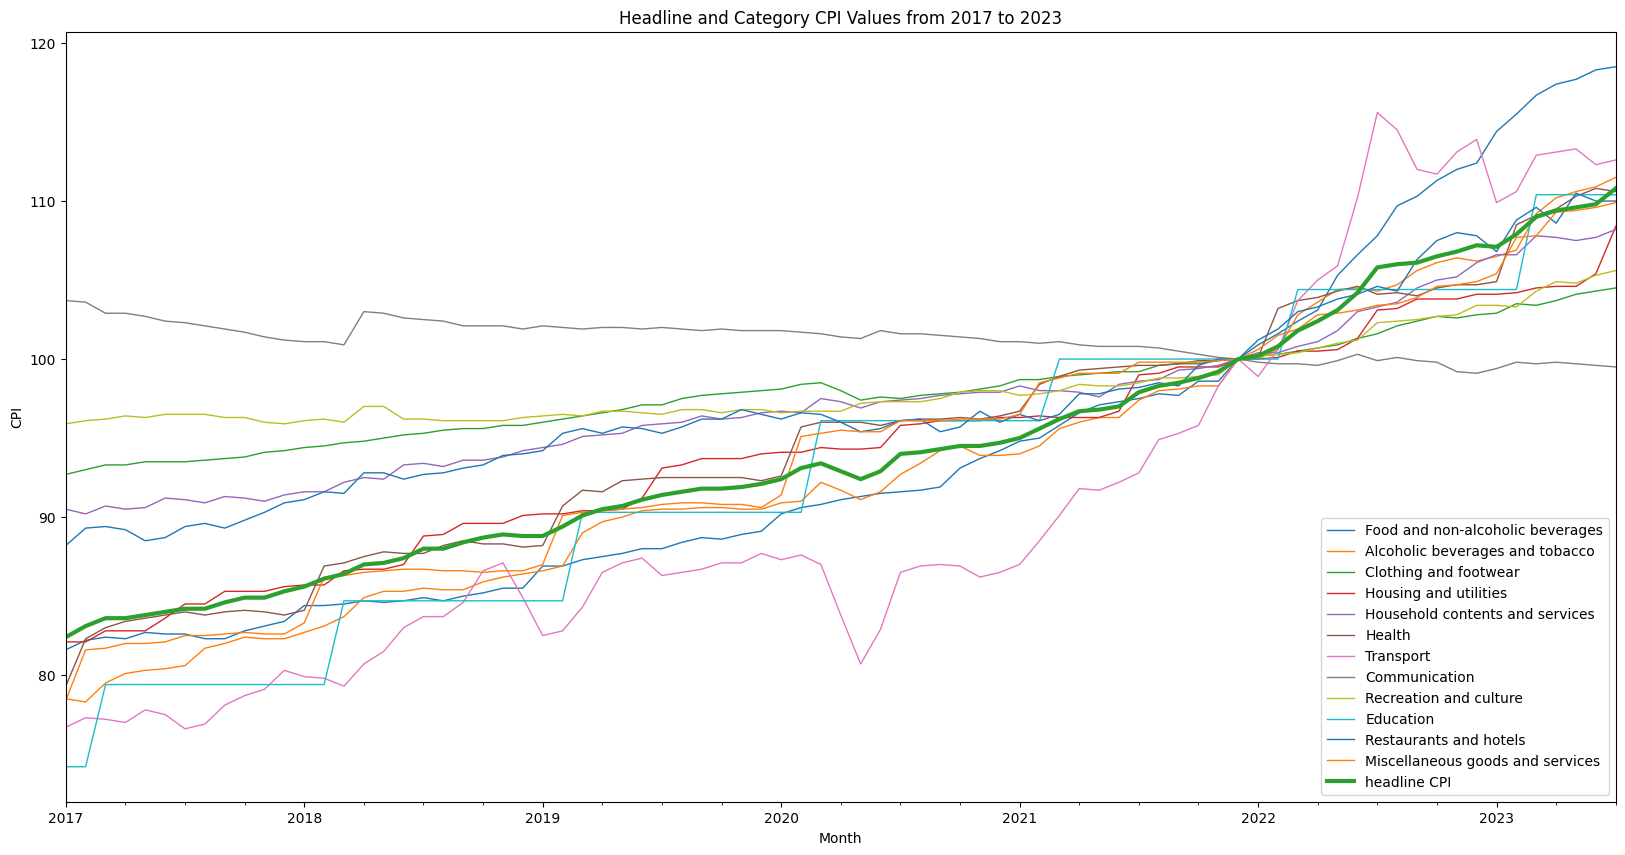

In [369]:
plot_montly_cpi(cpi_df=cpi, cat_dict=category_dict)

## Review Categories Individualy
Fit an ARIMA to each category and forecast new CPI values.

Determine if the forecasted values can be improved by importing additional data and fitting a VAR or VARIMA model.

In [370]:
def find_best_model(train_series, test_series, colname):
        """Function that finds the best model based on performance.

        Arguments:
        ----------
        train_series: pandas dataframe
                      dataframe with monthly cpi values to train model
        test_seriesL: pandas dataframe
                      dataframe that contains unseen cpi values to test model (used to find the best model)
        colname: str
                 name of category
        
        Returns:
        --------
        model: fitted model

        """

        # Determine the number of seasonal differences using a Canova-Hansen test
        seasonal_diff = nsdiffs(train_series,
                m=12,  # commonly requires knowledge of dataset
                max_D=12,
                test='ch')  # -> 0
        print(seasonal_diff)
    
        # Fit the auto_arima model and find the best model
        model = pm.auto_arima(train_series, 
                        start_p=1, 
                        start_q=1,
                        test='adf',        # use adftest to find optimal 'd'
                        max_p=3, max_q=3,  # maximum p and q
                        m=12,              # frequency of series
                        d=None,            # let model determine 'd'
                        seasonal=True,     # Seasonality
                        start_P=1, 
                        D=seasonal_diff,
                        start_Q=1,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

        print(model.summary()) 
    
        # Fit the model
        model.fit(train_series)
        
        # Forecast and compare with the test value
        forecast=model.predict(n_periods=2, return_conf_int=True)
        forecast_df = pd.DataFrame(forecast[0], index=arima_test['01'].index,columns=['Prediction'])
        
        rmse = np.mean((forecast_df['Prediction'] - test_series)**2)**.5  # RMSE
        print('\n')
        print(f'RMSE: {rmse}')
        
        # Plot the train, test and predicted values
        ax = pd.concat([train_series, test_series, forecast_df], axis=1).plot(figsize=(8,4))

        # Modify the legend labels
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['train', 'test', 'prediction'])
        plt.show()
        
        return model

In [371]:
def forecast_unseen_values(dataframe, colname, model, periods_to_predict, forecast_start_date):

       """Function used to make prediction
       
       Arguments:
       ---------
       dataframe: pandas dataframe
                     contains montly cpi values
       colname: str
              name of category
       model: model object
              fitted Arima model
       periods_to_predict: int
                            forecast period
       forecast_start_date: str
                            date of forecast

       Returns:
       --------
       forecast_unseen_df: pandas dataframe
                            dataframe with unseen forcast value
       """

       model.fit(dataframe[colname])
       
       forecast_unseen=model.predict(n_periods=periods_to_predict, return_conf_int=True)
       
       forecast_range=pd.date_range(start=forecast_start_date, periods=periods_to_predict, freq='M')
       
       forecast_unseen_df = pd.DataFrame(forecast_unseen[0], index=forecast_unseen[0].index,columns=['Prediction'])
       
       # Add last predicted value to CPI dictionary
       cpi_dict[colname] = [forecast_unseen_df.index.astype(str)[-1:].item(), 
                            forecast_unseen_df[-1:]['Prediction'].item()]
    
       # Plot the new forecasted values
       ax = dataframe[colname].plot(figsize=(8,4))
       forecast_unseen_df.plot(ax=ax, marker='o', markersize=3)

       # Modify the legend labels
       handles, labels = ax.get_legend_handles_labels()
       plt.legend(handles, ['actual', 'prediction'])
       plt.show()
       
       return forecast_unseen_df

### Create train and test data sets and a dictionary to store the predicted CPI values

In [372]:
# Create a dictionary where the predicted CPI for each category will be stored.
cpi_dict={}

In [373]:
# monthly_cpi_df
# Only use the last 24 months for training
reduced_monthly_cpi = cpi.drop(index=cpi.index[:24]).copy()

In [374]:
def create_test_and_train(df, len_test_df):
    """Function to split dataframe into training and testting
    
    Arguments:
    ----------
    df: pandas dataframe
        dataframe to split
    len_test_df: int
                 length of test dataframe
    
    Returns:
    --------
    train: pandas dataframe
           training dataframe
    test: pandas dataframe
          testting dataframe
    """
    
    # Split train and test
    train = df.iloc[:-len_test_df]
    test = df.iloc[-len_test_df:]
        
    return train, test

In [375]:
arima_train, arima_test = create_test_and_train(reduced_monthly_cpi, len_test_df=2)

### Category 1: Food and non-alcoholic beverages

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=78.420, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=84.427, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=81.092, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=83.918, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=125.193, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=76.294, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=74.534, Time=0.12 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=76.311, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=82.067, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=79.142, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=76.112, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=76.256, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=74.365, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=76.365, Time=0.21 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=7

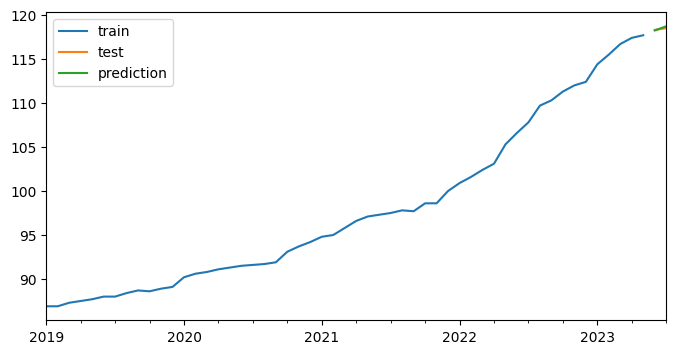

In [376]:
cat_model = find_best_model(arima_train['01'], arima_test['01'], colname='01')

##### Forecast the new CPI values

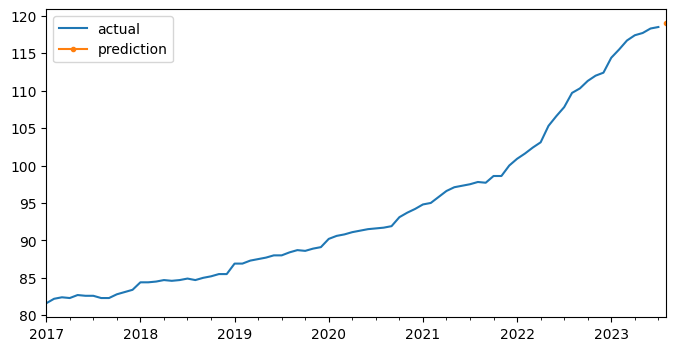

In [377]:
unseen_forecast = forecast_unseen_values(cpi, colname='01', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [378]:
unseen_forecast

,Prediction
2023-08-01,118.998437


### Category 2: Alcoholic beverages and tobacco

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=102.563, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=98.067, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=98.397, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=123.239, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=103.286, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=99.419, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=98.836, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=96.633, Time=1.37 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=98.080, Time=1.43 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=98.277, Time=1

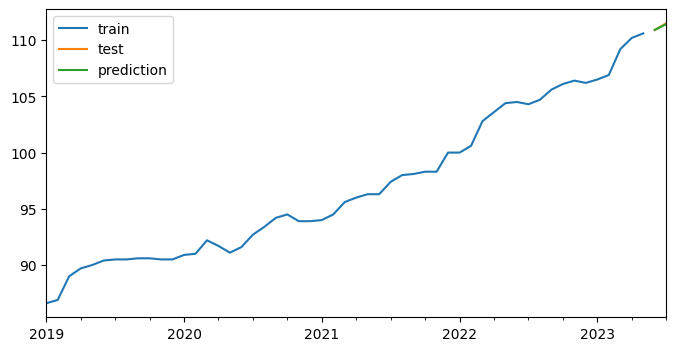

In [379]:
cat_model = find_best_model(arima_train['02'], arima_test['02'], colname='02')

##### Forecast the new CPI values

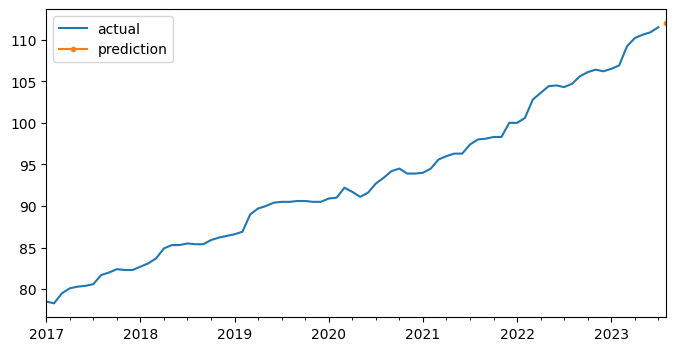

In [380]:
unseen_forecast = forecast_unseen_values(cpi, colname='02', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [381]:
unseen_forecast

,Prediction
2023-08-01,111.976254


### Category 3: Clothing and footwear

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-6.651, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=10.100, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-0.683, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-10.155, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-11.912, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-10.136, Time=0.11 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-8.234, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-10.245, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=-10.161, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-2.530, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.220 seconds
                               SARIMAX Results                                
Dep. Variable:     

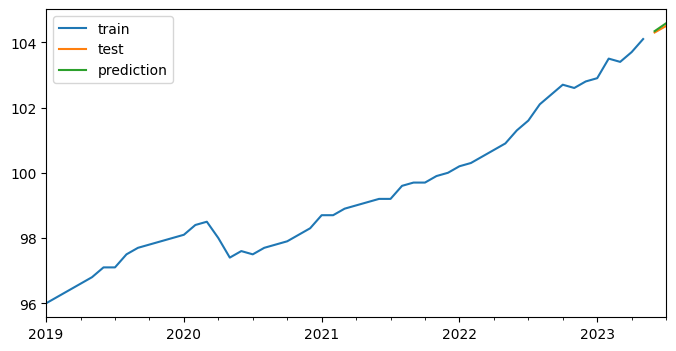

In [382]:
cat_model = find_best_model(arima_train['03'], arima_test['03'], colname='03')

##### Forecast the new CPI values

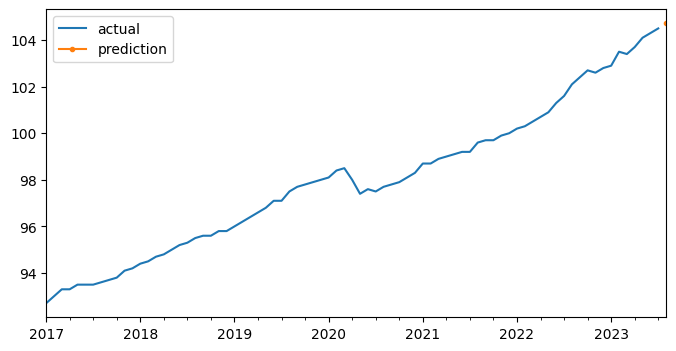

In [383]:
unseen_forecast = forecast_unseen_values(cpi, colname='03', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [384]:
unseen_forecast

,Prediction
2023-08-01,104.721144


### Category 4: Housing and utilities

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=11.049, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=79.452, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26.184, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=91.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=27.498, Time=0.27 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=11.167, Time=1.21 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=83.173, Time=0.06 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=14.287, Time=1.13 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=9.528, Time=0.41 sec

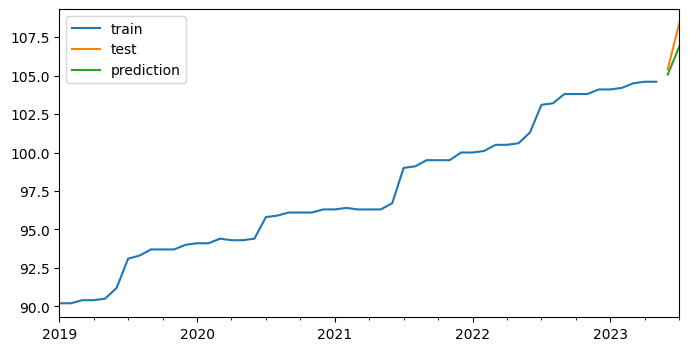

In [385]:
cat_model = find_best_model(arima_train['04'], arima_test['04'], colname='04')

##### Forecast the new CPI values

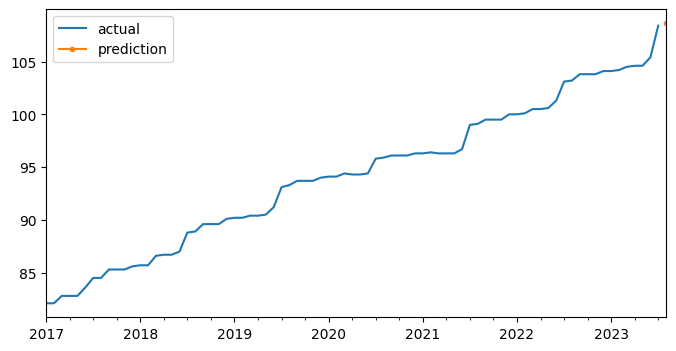

In [386]:
unseen_forecast = forecast_unseen_values(cpi, colname='04', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [387]:
unseen_forecast

,Prediction
2023-08-01,108.625987


### Category 5: Household contents and services

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=78.414, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=56.775, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=40.823, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=45.590, Time=0.03 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=42.737, Time=0.21 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=40.296, Time=0.11 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=41.285, Time=0.41 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=64.652, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=41.972, Time=0.13 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=41.217, Time=0.18 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=39.719, Time=0.30 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=47.318, Tim

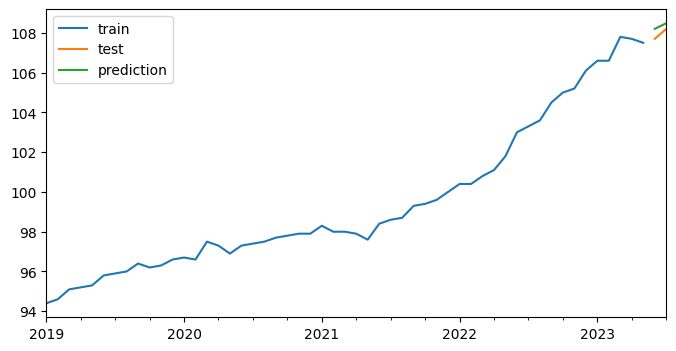

In [388]:
cat_model = find_best_model(arima_train['05'], arima_test['05'], colname='05')

##### Forecast the new CPI values

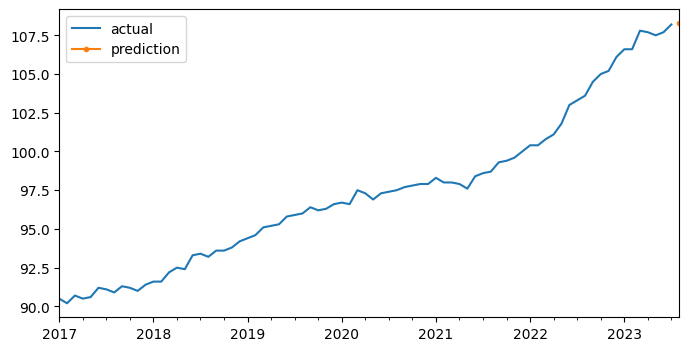

In [389]:
unseen_forecast = forecast_unseen_values(cpi, colname='05', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [390]:
unseen_forecast

,Prediction
2023-08-01,108.27671


### Category 6: Health

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=77.258, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=133.587, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=81.103, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=143.409, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=81.123, Time=0.60 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=79.366, Time=1.51 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=79.352, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=136.872, Time=0.06 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=103.189, Time=0.33 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=81.704, Time=0.65 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=75.379, Time=0.41 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=81.023,

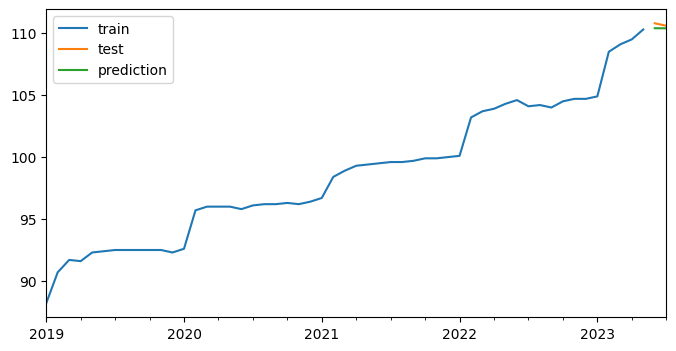

In [391]:
cat_model = find_best_model(arima_train['06'], arima_test['06'], colname='06')

##### Forecast the new CPI values

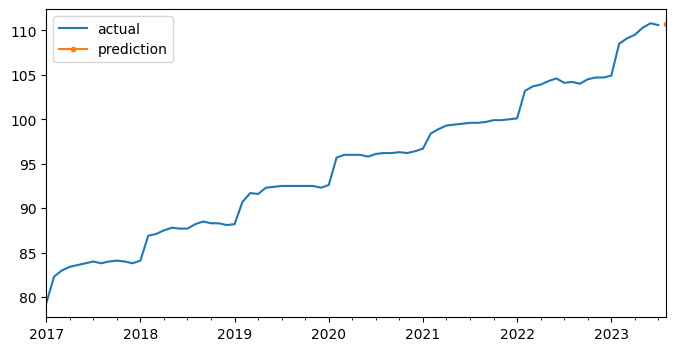

In [392]:
unseen_forecast = forecast_unseen_values(cpi, colname='06', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [393]:
unseen_forecast

,Prediction
2023-08-01,110.689981


### Category 7: Transport

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=219.469, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=222.415, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=209.193, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=207.194, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=209.193, Time=0.13 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=221.143, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.803 seconds
                               SARIMAX Results                                
Dep. Variable:                

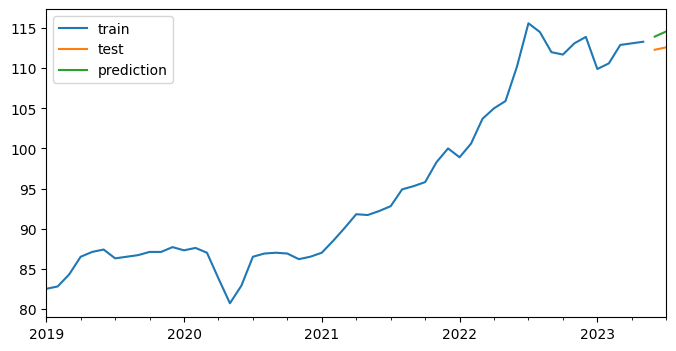

In [394]:
cat_model = find_best_model(arima_train['07'], arima_test['07'], colname='07')

##### Forecast the new CPI values

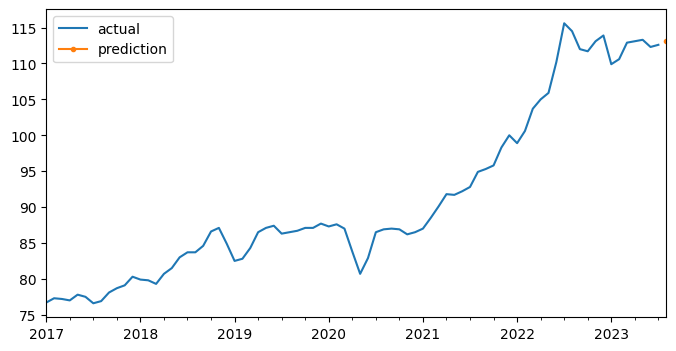

In [395]:
unseen_forecast = forecast_unseen_values(cpi, colname='07', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [396]:
unseen_forecast

,Prediction
2023-08-01,113.10455


### Category 8: Communication

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-22.492, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-18.555, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-18.559, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-21.435, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-20.497, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-20.496, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-18.836, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-20.555, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-20.559, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 2.120 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
M

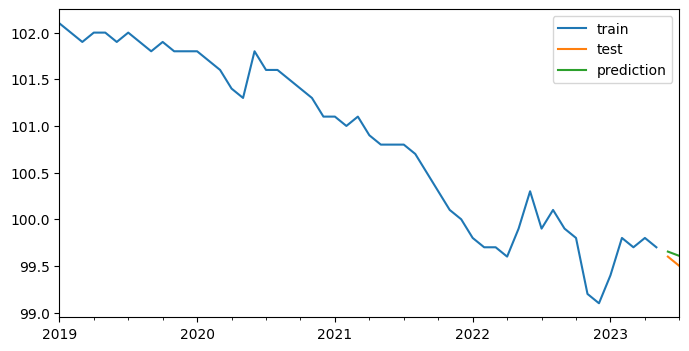

In [397]:
cat_model = find_best_model(arima_train['08'], arima_test['08'], colname='08')

##### Forecast the new CPI values

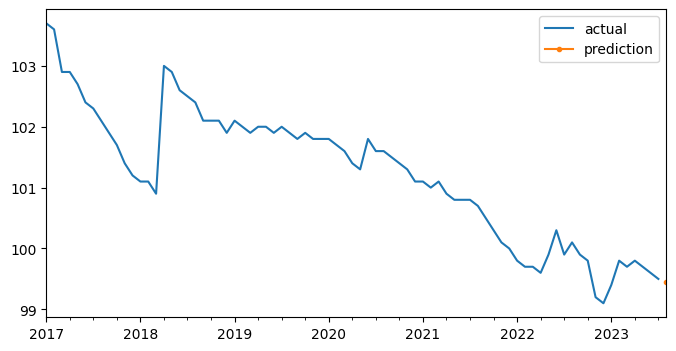

In [398]:
unseen_forecast = forecast_unseen_values(cpi, colname='08', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [399]:
unseen_forecast

,Prediction
2023-08-01,99.446154


### Category 9: Recreation and culture

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=27.366, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=21.014, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=24.786, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=24.758, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=33.503, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=22.876, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=22.895, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=24.858, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=22.942, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=22.900, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=23.507, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.421 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Mode

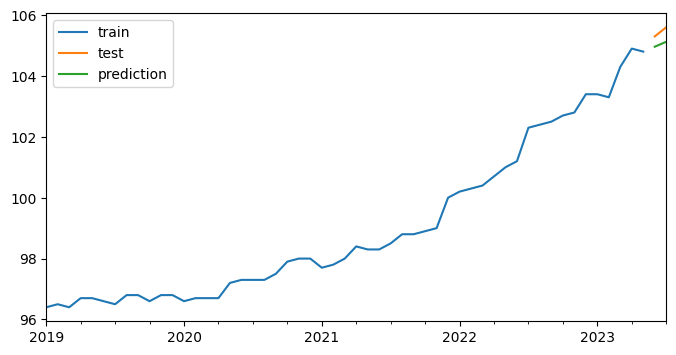

In [400]:
cat_model = find_best_model(arima_train['09'], arima_test['09'], colname='09')

##### Forecast the new CPI values

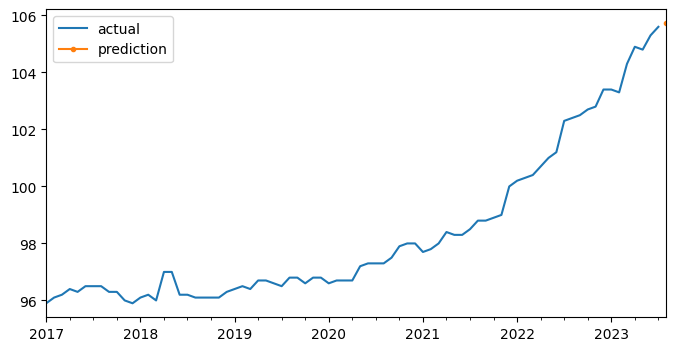

In [401]:
unseen_forecast = forecast_unseen_values(cpi, colname='09', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [402]:
unseen_forecast

,Prediction
2023-08-01,105.724359


### Category 10: Education

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=107.406, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=349.645, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=638.556, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=107.983, Time=0.34 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=212.916, Time=0.16 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=109.824, Time=0.93 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=105.455, Time=0.57 s

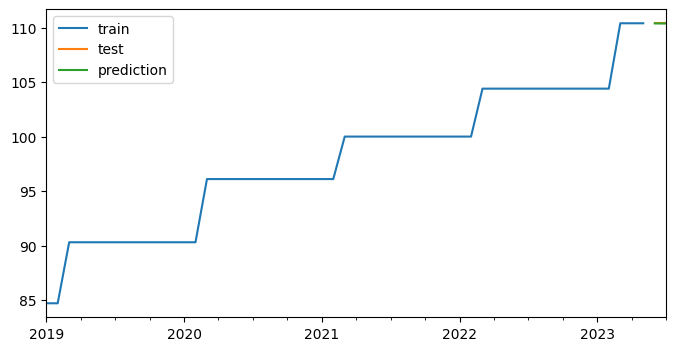

In [403]:
cat_model = find_best_model(arima_train['10'], arima_test['10'], colname='10')

##### Forecast the new CPI values

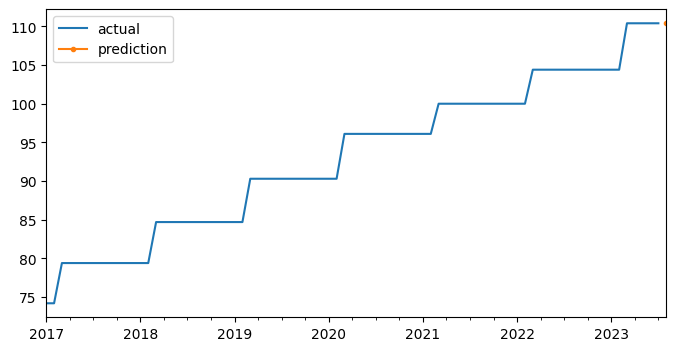

In [404]:
unseen_forecast = forecast_unseen_values(cpi, colname='10', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [405]:
unseen_forecast

,Prediction
2023-08-01,110.389227


### Category 11: Restaurants and hotels

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=120.053, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=113.529, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=116.310, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=114.549, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=121.192, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=115.247, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=113.786, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=117.143, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=114.706, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=114.434, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=116.371, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.603 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               

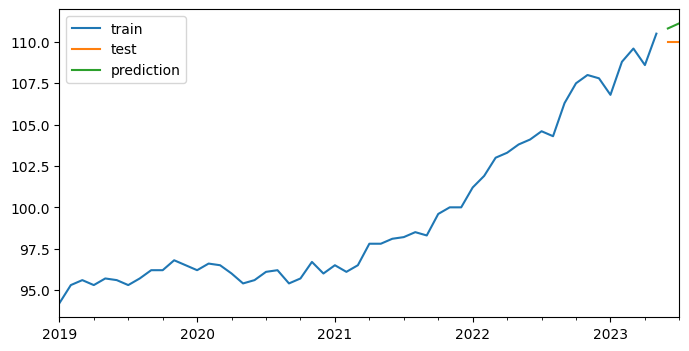

In [406]:
cat_model = find_best_model(arima_train['11'], arima_test['11'], colname='11')

##### Forecast the new CPI values

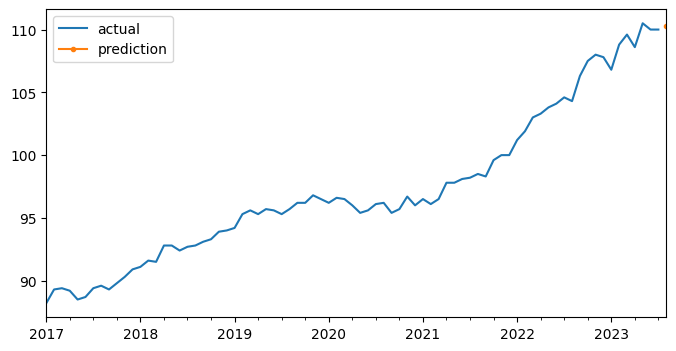

In [407]:
unseen_forecast = forecast_unseen_values(cpi, colname='11', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [408]:
unseen_forecast

,Prediction
2023-08-01,110.279487


### Category 12: Miscellaneous goods and services

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=124.049, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=85.239, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=136.289, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=126.002, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=87.223, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=83.248, Time=0.10 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=85.234, Time=0.21 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 

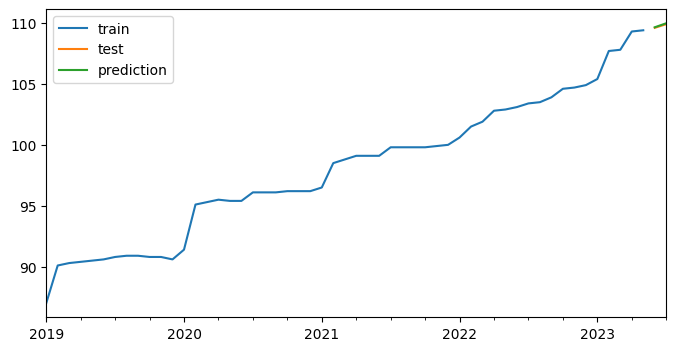

In [409]:
cat_model = find_best_model(arima_train['12'], arima_test['12'], colname='12')

##### Forecast the new CPI values

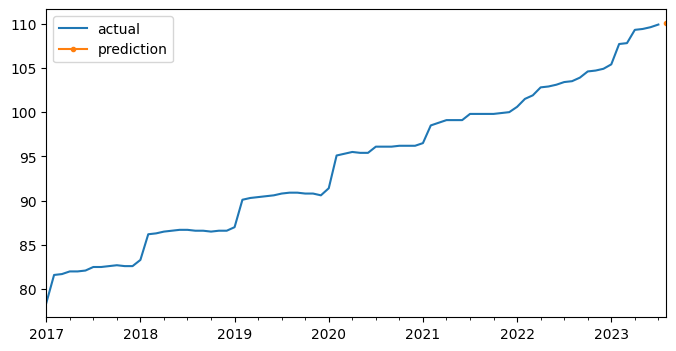

In [410]:
unseen_forecast = forecast_unseen_values(cpi, colname='12', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [411]:
unseen_forecast

,Prediction
2023-08-01,110.043163


### Headline CPI

##### ARIMA
Use auto_arima to find the best model.

0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=30.239, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=50.322, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=39.166, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=34.536, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=87.428, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=33.247, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=30.122, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=37.444, Time=0.06 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=29.542, Time=0.43 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=31.433, Time=0.83 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=29.066, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=30.402, Time=0.16 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=30.635, Time=0.70 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=30.326, Time=0.25 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=46

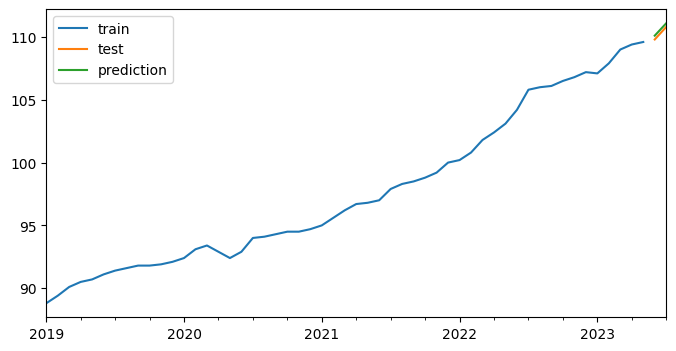

In [412]:
cat_model = find_best_model(arima_train['headline'], arima_test['headline'], colname='headline')

##### Forecast the new CPI values

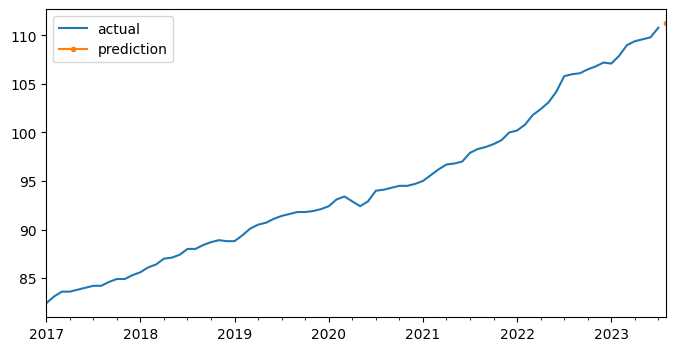

In [413]:
unseen_forecast = forecast_unseen_values(cpi, colname='headline', model=cat_model, periods_to_predict=1, 
                       forecast_start_date=forecast_start_date)

In [414]:
unseen_forecast

,Prediction
2023-08-01,111.249654


### Create Dataframe for Submission

In [415]:
prediction_df = pd.DataFrame.from_dict(cpi_dict,orient='index', columns=['Year_Month', 'Value']).reset_index().rename(columns={'index': 'ID'})

In [416]:
pred_month = pd.to_datetime(prediction_df['Year_Month'].unique()[0]).strftime('%B')
pred_month

'August'

In [417]:
# drop the month from the dataframe
prediction_df.drop(['Year_Month'], axis=1, inplace=True)

In [418]:
# Create a dictionary to update the category names to allow a submission to Zindi.
# month="May"
pred_category_dict = {"01":pred_month+"_food and non-alcoholic beverages",
                      "02":pred_month+"_alcoholic beverages and tobacco",
                      "03":pred_month+"_clothing and footwear",
                      "04":pred_month+"_housing and utilities",
                      "05":pred_month+"_household contents and services",
                      "06":pred_month+"_health",
                      "07":pred_month+"_transport",
                      "08":pred_month+"_communication",
                      "09":pred_month+"_recreation and culture",
                      "10":pred_month+"_education",
                      "11":pred_month+"_restaurants and hotels",
                      "12":pred_month+"_miscellaneous goods and services",
                      "headline":pred_month+"_headline CPI"
}

In [419]:
prediction_df = prediction_df.replace(pred_category_dict)
prediction_df

,ID,Value
0,August_food and non-alcoholic beverages,118.998437
1,August_alcoholic beverages and tobacco,111.976254
2,August_clothing and footwear,104.721144
3,August_housing and utilities,108.625987
4,August_household contents and services,108.276710
5,August_health,110.689981
6,August_transport,113.104550
7,August_communication,99.446154
8,August_recreation and culture,105.724359
9,August_education,110.389227


In [420]:
# output to csv file
prediction_df.to_csv(path + f'/submissions/auto_arima_{month}.csv', index = 0)